In [1]:
import os
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
import matplotlib.pyplot as plt
from Whittaker_assymetric_LSQ_filter import *
from JCampSG import JCAMP_calc_xsec, JCAMP_reader
import scipy as sp
from scipy.interpolate import CubicSpline, PchipInterpolator
import datetime
from numpy import array, append, arange, logical_not, log10, nan, isnan, linspace, amax, amin
import re
import pdb

In [2]:
def jcamp_calc_xsec(jcamp_dict, wavemin=None, wavemax=None, skip_nonquant=True, debug=False):
    x = np.array(jcamp_dict['x']) ## use 'array' to force a copy so that we cannot change the original data
    y = np.array(jcamp_dict['y'])  ## use 'array' to force a copy so that we cannot change the original data

    T = 296.0            ## the temperature (23 degC) used by NIST when collecting spectra
    R = 1.0355E-25       ## the constant for converting data (includes the gas constant)

    ## Note: normally when we convert from wavenumber to wavelength units, the ordinate must be nonuniformly
    ## rescaled in order to compensate. But this is only true if we resample the abscissa to a uniform sampling
    ## grid. In this case here, we keep the sampling grid nonuniform in wavelength space, such that each digital
    ## bin retains its proportionality to energy, which is what we want.
    if (jcamp_dict['xunits'].lower() in ('1/cm', 'cm-1', 'cm^-1')):
        jcamp_dict['wavenumbers'] = array(x)            ## note that array() always performs a copy
        x = 10000.0 / x
        jcamp_dict['wavelengths'] = x
    elif (jcamp_dict['xunits'].lower() in ('micrometers', 'um', 'wavelength (um)')):
        jcamp_dict['wavelengths'] = x
        jcamp_dict['wavenumbers'] = 10000.0 / x
    elif (jcamp_dict['xunits'].lower() in ('nanometers', 'nm', 'wavelength (nm)')):
        x = x / 1000.0
        jcamp_dict['wavelengths'] = x
        jcamp_dict['wavenumbers'] = 10000.0 / x
    else:
        raise ValueError('Don\'t know how to convert the spectrum\'s x units ("' + jcamp_dict['xunits'] + '") to micrometers.')
   # print(x)
    ## Correct for any unphysical negative values.
    y[y < 0.0] = 0.0

    ## Make sure "y" refers to absorbance.
    if (jcamp_dict['yunits'].lower() == 'transmittance'):
        ## If in transmittance, then any y > 1.0 are unphysical.
        y[y > 1.0] = 1.0

        ## Convert to absorbance.
        okay = (y > 0.0)
        y[okay] = log10(1.0 / y[okay])
        y[logical_not(okay)] = np.nan
        

        jcamp_dict['absorbance'] = y
    elif (jcamp_dict['yunits'].lower() == 'absorbance'):
        jcamp_dict['absorbance'] = y
        
    elif (jcamp_dict['yunits'].lower() == '(micromol/mol)-1m-1 (base 10)'):
        jcamp_dict['yunits'] = 'xsec (m^2))'
        jcamp_dict['xsec'] = y / 2.687e19
        return
    else:
        raise ValueError('Don\'t know how to convert the spectrum\'s y units ("' + jcamp_dict['yunits'] + '") to absorbance.')
    #print(y)
    ## Determine the effective path length "ell" of the measurement chamber, in meters.
    if (('path length' in jcamp_dict) and jcamp_dict['path length'].lower().split()[0:2] ==2):
        print(jcamp_dict['path length'])
        #if jcamp_dict['path length'].lower().split()[0:2] ==2:
        (val,unit) = jcamp_dict['path length'].lower().split()[0:2]
        if (unit == 'cm'):
            ell = float(val) / 100.0
        elif (unit == 'm'):
            ell = float(val)
        elif (unit == 'mm'):
            ell = float(val) / 1000.0
        else:
            ell = 0.1
        
    else:
        if skip_nonquant: return({'info':None, 'x':None, 'xsec':None, 'y':None})
        ell = 0.1
        if debug: print('Path length variable not found. Using 0.1m as a default ...')

    assert(len(x) == len(y))

    if ('npoints' in jcamp_dict):
        if (len(x) != jcamp_dict['npoints']):
            npts_retrieved = str(len(x))
            msg = '"' + jcamp_dict['title'] + '": Number of data points retrieved (' + npts_retrieved + \
                  ') does not equal the expected length (npoints = ' + str(jcamp_dict['npoints']) + ')!'
            raise ValueError(msg)

    ## For each gas, manually define the pressure "p" at which the measurement was taken (in units of mmHg).
    ## These values are obtained from the NIST Infrared spectrum database, which for some reason did not
    ## put the partial pressure information into the header.
    if ('partial_pressure' in jcamp_dict):
        p = float(jcamp_dict['partial_pressure'].split()[0])
        p_units = jcamp_dict['partial_pressure'].split()[1]
        if (p_units.lower() == 'mmhg'):
            pass
        elif (p_units.lower() == 'ppm'):
            p = p * 759.8 * 1.0E-6       ## scale PPM units at atmospheric pressure to partial pressure in mmHg
    else:
        if debug: print('Partial pressure variable value for ' + jcamp_dict['title'] + ' is missing. Using the default p = 150.0 mmHg ...')
        if skip_nonquant: return({'info':None, 'x':None, 'xsec':None, 'y':None})
        p = 150.0

    ## Convert the absorbance units to cross-section in meters squared per molecule.
    xsec = y * T * R / (p * ell)

    ## Add the "xsec" values to the data dictionary.
    jcamp_dict['xsec'] = xsec

    return jcamp_dict

In [3]:
def closest(myList, myNumber):
    #Find num in list closest to mynum, used in preprocess
    from bisect import bisect_left
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before
    
def process_file(filename):
    """Convert spectrum units to wavenumbers (x) and transmittance (y), and interpolate any missing coordinates
    , then return a list of transmitances"""
    #TODO: ask if nitrogen dilution matters at all
    #MIN: 450, MAX: 4914, increments of 2
    spectrum = JCAMP_reader(filename)
    try:
        jcamp_calc_xsec(spectrum, skip_nonquant = False, wavemin=400, wavemax=4914)
        return  spectrum

        #if(spectrum["state"] != "gas" and spectrum['state'] != "GAS"):
            #print("wrong state", spectrum["state"])
           # return(False)
        #else: return  spectrum
    except:
        return(False)
    #plt.plot()


def why_bad(filename):
    spectrum = JCAMP_reader(filename)
    try:
        spectrum=jcamp_calc_xsec(spectrum, skip_nonquant = False, wavemin=400, wavemax=4914)
        #if(spectrum["state"] != "gas" and spectrum['state'] != "GAS"):
           # return(spectrum["state"])
        if (spectrum.get('npoints')<1600):
            return("too few points")
        if (spectrum.get('maxx')<3500) or (spectrum.get('minx')>600):
            return("too small range")
        else: return("Unknown error")
    except:
        if "state" not in spectrum:
            return( "No State")
        else: 
            print(filename, "error")
            return("Couldn't read file")
    pass



In [4]:
PATH = "../IR-Spectra-Prediction-Graph-Models/jdx"
SMILES = []
spectra = []
phase=[]
bad, reason_bad = 0, []
x_new=np.arange(400, 4002, 2) #updated limits

for spectrafile in tqdm(os.listdir(PATH)[0:100]):
 
    try:
        spectrum = process_file(PATH + "/" + spectrafile) 
        
    except:
        bad += 1
        continue
    if (type(spectrum) != dict):
        reason_bad.append(why_bad(PATH + "/" + spectrafile))
        continue
    if spectrum.get("xunits")=="MICROMETERS":
            spectrum["maxx"]=spectrum.get("maxx")*100
            spectrum["minx"]=spectrum.get("minx")*100
            print("changed")
    if (spectrum.get('maxx')<3500) or (spectrum.get('minx')>700):
        print(spectrum.get('npoints'),spectrum.get('maxx'),spectrum.get('minx'))
        reason_bad.append(why_bad(PATH + "/" + spectrafile))
        continue
        #if spectrum.get("xunits")=="MICROMETERS":
         #   spectrum["maxx"]=spectrum.get("maxx")*100
          #  spectrum["minx"]=spectrum.get("minx")*100
           # print("changed")
            
        #if (spectrum.get('maxx')<3500) or (spectrum.get('minx')>600):
         #   print(spectrum.get('npoints'),spectrum.get('maxx'),spectrum.get('minx'))
          #  reason_bad.append(why_bad(PATH + "/" + spectrafile))
           # continue
        
    else:
    #Get the smiles out of the mol using rdkit
        abs_raw=(spectrum.get("absorbance")) #get raw absorbance
        
        x_raw=(spectrum.get("wavenumbers"))  #get raw wavenumbers
        df=pd.DataFrame(x_raw, abs_raw, columns=["x"]).drop_duplicates().sort_values("x").fillna(0)
        #print(df)
        abs_raw=df.index.values
        
       # print(len(abs_raw))
        x_raw=df["x"]
        try: 
            f = CubicSpline(x=x_raw, y=abs_raw, extrapolate=False)
            abs_new = f(x_new)
        except: 
            print ("nan exist")
            abs_raw=np.nan_to_num(abs_raw)
            f = CubicSpline(x=x_raw, y=abs_raw, extrapolate=False)
            abs_new = f(x_new)
            
            continue
        
        molfile = "../IR-Spectra-Prediction-Graph-Models/mol/" + spectrafile[:-7] + ".mol"
    
        mol = Chem.MolFromMolFile(molfile)
        if mol is None:
            pass 
        else:
            sm = Chem.MolToSmiles(mol)
       # SMILES.append(sm)
        try:
            sm = Chem.MolToSmiles(mol)
        except:
            continue  
        
        if(sm != ""):
            #spectra.append(spectrum.get("absorbance"))
            spectra.append(abs_new)
            SMILES.append(sm)
            phase.append(spectrum.get("state"))
      
    

 13%|██████████████████████████████▉                                                                                                                                                                                                               | 13/100 [00:00<00:01, 65.02it/s]

changed
2032 1591.78 203.39999999999998


 28%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 28/100 [00:00<00:01, 66.72it/s]

changed
2080 1591.51 204.6
changed
1954 1500.69 202.70000000000002


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 45/100 [00:00<00:00, 67.66it/s]

changed
2052 1598.08 202.0
changed
2004 1549.6100000000001 206.2
changed
2264 1600.6499999999999 202.5
changed
2096 1598.32 206.3
1961 3348.13 653.125


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 59/100 [00:00<00:00, 59.55it/s]

changed
1959 1502.6 204.6
3270 4000 731
changed
2859 1599.4199999999998 199.6
changed
1961 1507.3 202.0
changed
1987 1601.4199999999998 205.10000000000002
changed
2860 1599.7 202.2


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 81/100 [00:01<00:00, 59.56it/s]

changed
2601 1501.5 202.0
changed
2049 1589.8300000000002 201.39999999999998
changed
1987 1526.0 204.0
nan exist
changed
2261 1600 201.9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.08it/s]

changed
1995 1540.99 201.29999999999998
changed
2796 1501.83 200
changed
1879 1541.3 204.6
changed
2049 1599.35 203.39999999999998


In [6]:
wl=[]
for i, s in enumerate(spectra):
    wl+= [len(s)]
min(wl), max(wl)
min_points=min(wl)
len(spectra),min_points, max(wl), len(SMILES)

(71, 1801, 1801, 71)

In [7]:
print(bad, "files couldn't be processed at all.")
from collections import Counter
print(Counter(reason_bad))
len(reason_bad) + len(spectra)

0 files couldn't be processed at all.
Counter({'too small range': 22, 'No State': 6})


99

In [50]:
datadict = {"smiles": SMILES, "phase":phase}
col_names=["smiles","phase"]
for j in (x_new):
    col_names.append(j)
for i in range(min_points):
    datadict[i] = []
for spectrum in spectra:
   
    for i in range(min_points):
        datadict[i].append(spectrum[i])
dataset = pd.DataFrame(data = datadict)
dataset.columns=col_names


In [51]:
to_drop=[]
for i, state in enumerate(dataset["phase"]):
    if "CCl4" in str(state):
        dataset.iloc[i,1]="CCl4"
    elif "KBr" in str(state):
        dataset.iloc[i,1]="KBr"
    elif "LIQUID" in str(state) or "liquid" in str(state):
        
        dataset.iloc[i,1]="liquid film"
        
    elif "GAS" in str(state) or "gas" in str(state):
        dataset.iloc[i,1]="gas"
    elif "MULL" in str(state):
        dataset.iloc[i,1]="nujol mull"
    else:
       # print(state)
        to_drop.append(i)
    
 #   if str(state) not in ['liquid film', 'nujol mull', 'gas', 'CCl4', 'KBr']:
       # print(state)
        to_drop.append(i)
dataset=dataset.drop(index=to_drop)
dataset=dataset.fillna(0)
dataset.index=dataset["smiles"]
dataset=dataset.drop(columns="smiles")

dataset.to_csv("scripts/sample_data/NIST_IR_Dataset.csv")
dataset["phase"].unique()

array(['liquid film', 'nujol mull', 'gas', 'CCl4', 'KBr'], dtype=object)

In [52]:
dataset["phase"].value_counts().sum()

11630

In [79]:
to_predict=dataset.iloc[:6,:1]

In [80]:
to_predict.to_csv("scripts/SMILES_to_predict.csv")

In [112]:
to_pca=dataset.iloc[:,1:]
print(to_pca.mean())
to_pca=to_pca.drop(index='FC(F)C(F)(F)F')
mean=to_pca.mean().values
to_pca=to_pca.sub(mean,axis='columns')


400     0.011337
402     0.012930
404     0.014351
406     0.014358
408     0.014437
          ...   
3992    0.042086
3994    0.041879
3996    0.041669
3998    0.041459
4000    0.041039
Length: 1801, dtype: float64


In [113]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(to_pca)

In [114]:

principal=PCA(n_components=3)
principal.fit(scaled_df)
x=principal.transform(scaled_df)

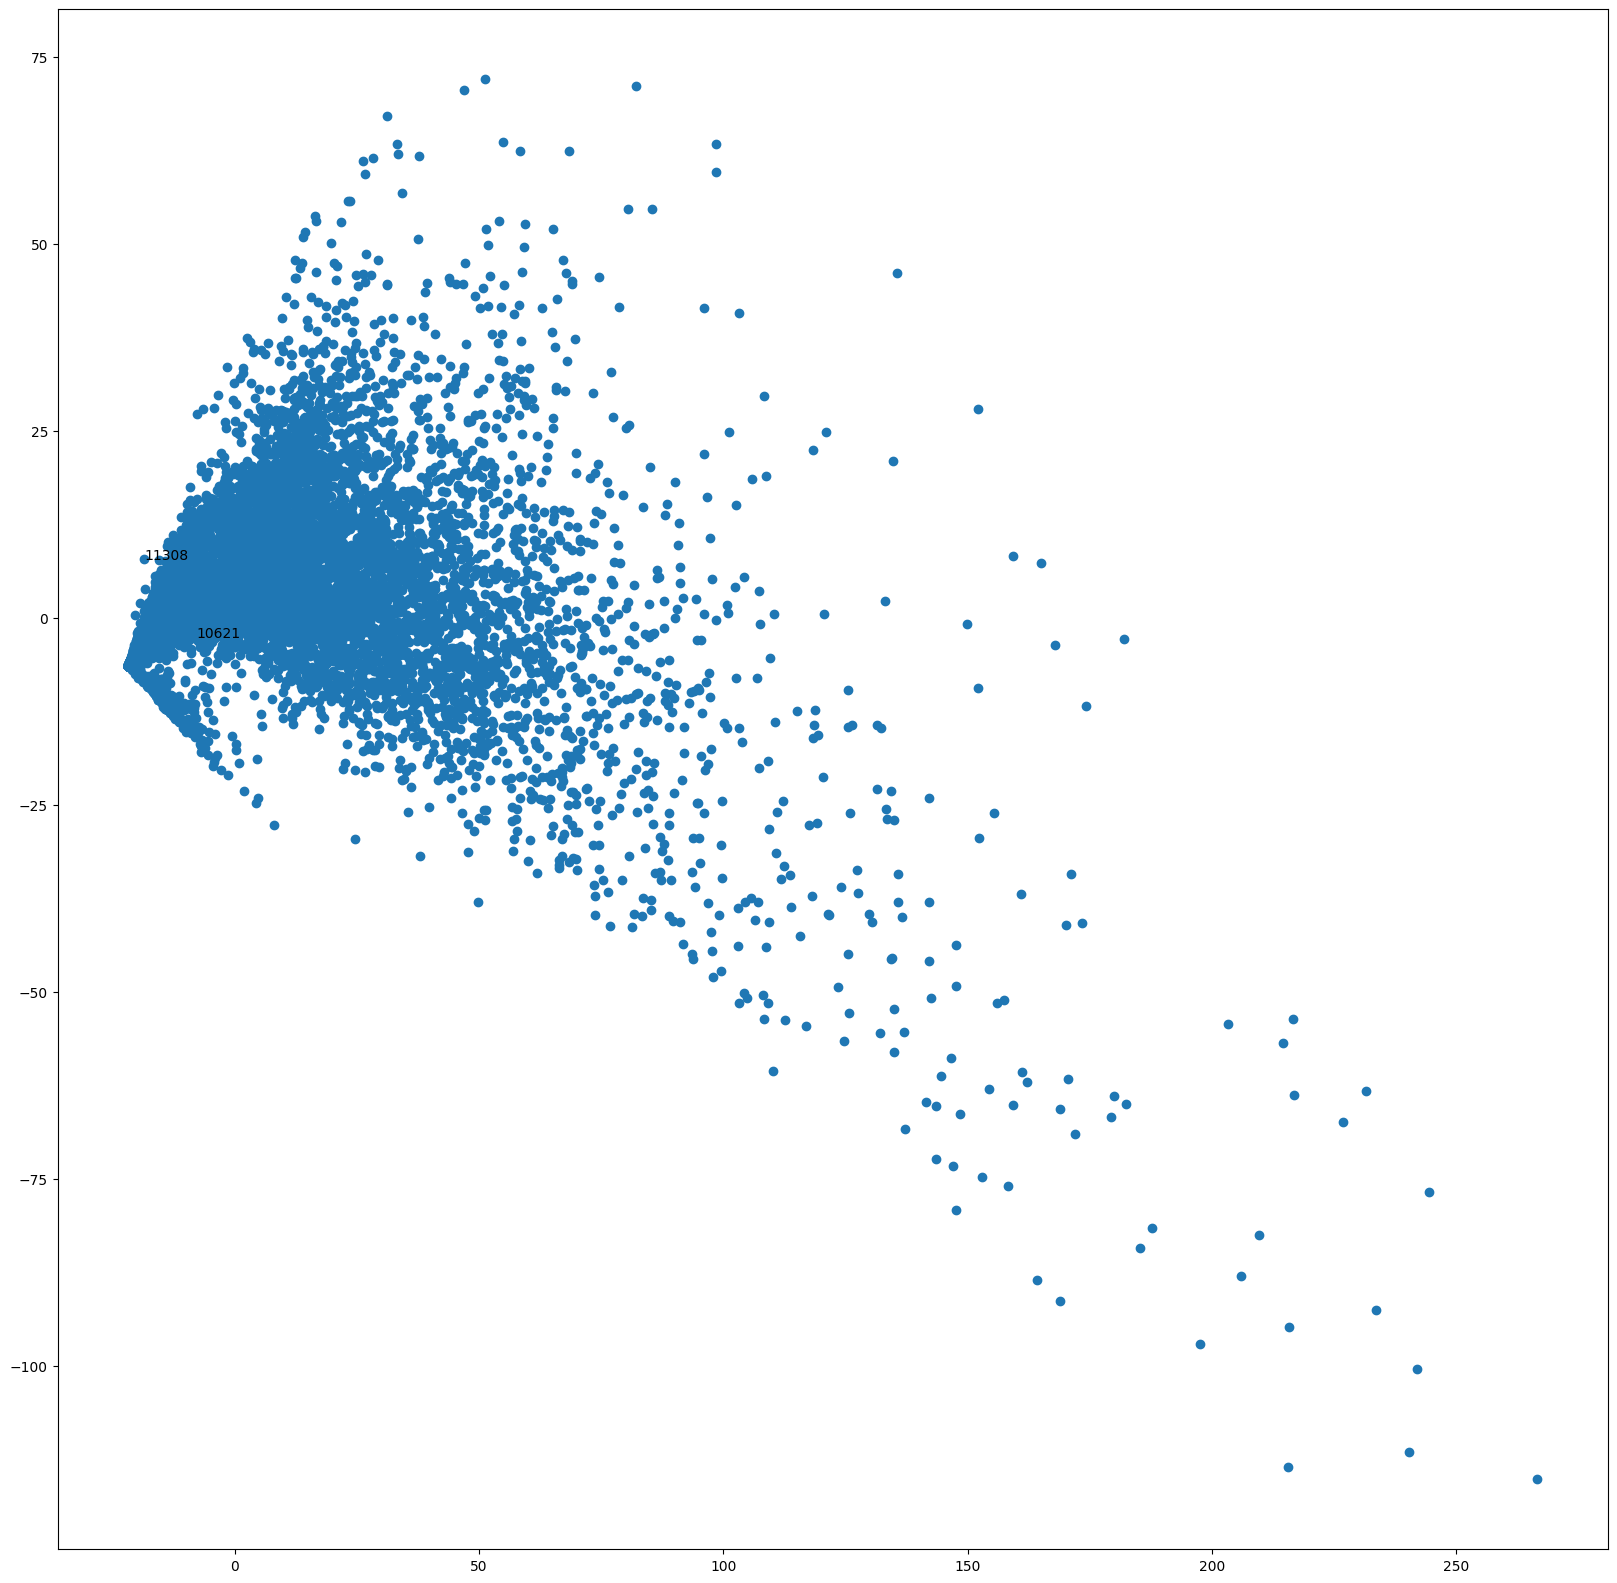

In [130]:

labels=to_pca.index
fig, ax = plt.subplots(figsize=(20,20))

# Scatter plot
ax.scatter(x[:,0], x[:,1])
#plt.xlim(150,290)
 #Add labels using text()
for i, label in enumerate(labels):
    if 'CCCCCCCCCc1ccc(O)cc1' in str(label):
       ax.text(x[i,0], x[i,1], i)

plt.show()

In [125]:
for i, name in enumerate(to_pca.index):
    if 'CCCCCCCCCc1ccc(O)cc1' in str(name):
        print (i)


10621
11308


400     0.124094
402     0.125794
404     0.141651
406     0.148687
408     0.149087
          ...   
3992   -0.042089
3994   -0.041882
3996   -0.041672
3998   -0.041462
4000   -0.041042
Name: CCCCCCCCCc1ccc(O)cc1, Length: 1801, dtype: float64

Text(0.5, 0, 'PC3')

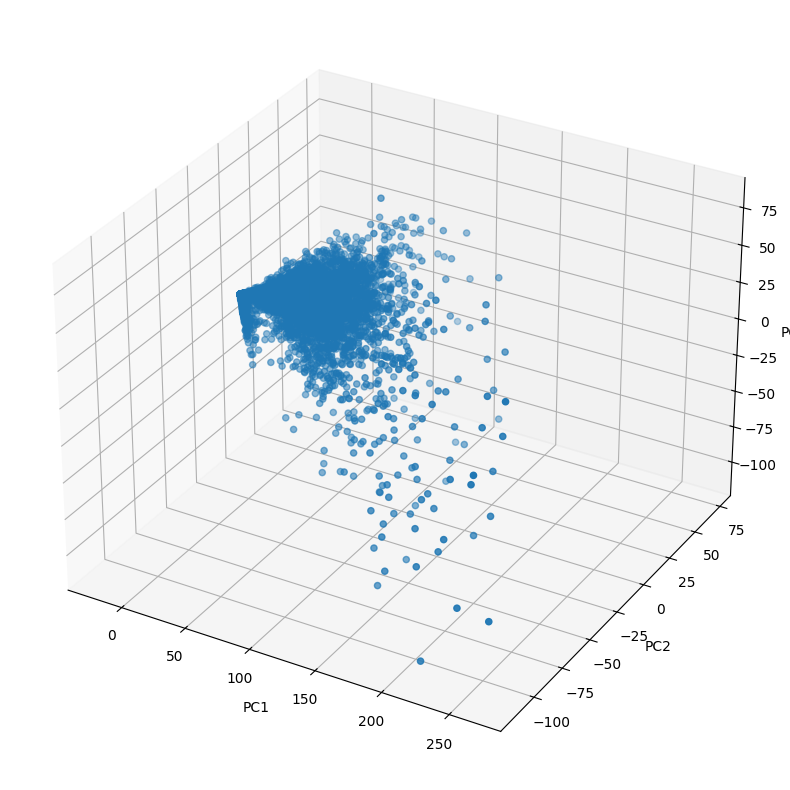

In [116]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2])
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

In [117]:
print(principal.explained_variance_ratio_)

[0.48089063 0.07339181 0.04813101]


In [19]:
from Whittaker_assymetric_LSQ_filter import *
Whittaker_asymmetric_LSQ_filter(spectra[0:1], True, 0)

AttributeError: 'list' object has no attribute 'shape'

In [24]:
import chemometrics as cm

In [25]:
whittaker = cm.Whittaker()
X_smoothed = whittaker.fit_transform(spectra[0])
aw = cm.AsymWhittaker(penalty=10000, asym_factor=0.99)
X_bg = aw.fit_transform(X_smoothed)

plt.figure(figsize=(15, 7))
lines = plt.plot(X.T, c=[0.8, 0.8, 0.8], alpha=0.1)
lines = cm.plot_colored_series(X_bg.T, reference=C)

plt.figure(figsize=(15, 7))
lines = plt.plot(aw.background_.T , c=[0, 0, 0.6], alpha=0.2)

ValueError: Expected 2D array, got 1D array instead:
array=[nan nan nan ... nan nan nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.